In [63]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import joblib
import duckdb
import sys
from pathlib import Path

# Import from local modules
sys.path.append('../src')
import clustering_analysis
import processing_and_visualization

import importlib
importlib.reload(clustering_analysis)
importlib.reload(processing_and_visualization)

from clustering_analysis import print_cluster_examples, summarize_clusters, metacluster_preview
from processing_and_visualization import load_clustered_questions, plot_metacluster_distribution

load_dotenv()
csv_path = os.getenv("DATA_CSV")
parquet_path = os.getenv("DATA_PARQUET")

# Final Analysis of Question Clustering
This notebook reconstructs the clustered question datasets for the *unlabeled*, *chicken*, and *maize* subsets of English questions using the provided cluster label files (<20 MB) and the original full dataset. It also includes tools for inspecting and visualizing the cluster structure.

Together, these pieces allow users to explore the final clustering results without rerunning the full UMAP + HDBSCAN pipeline.

Quick facts about the full dataset:
* 20,304,843 rows in total
* 18,854,432 unique rows
* 5,452,290 unique questions
* 2,940,542 unique questions in English
* 16,283,143 unique responses
* 1,537,291 unique questions with no topic tag

Along with commentary, the rest of the notebook will go through the three clustered topics with the following:
- Visualization of the 2D UMAP projections of cluster centroids, color-coded by ChatGPT-assigned metacluster label.
- Bar plot of the amount of questions in each metacluster.
- Summary of HDBSCAN clusters, including TF-IDF keywords, 5 example questions, and metacluster label.
- A function to explore a single metacluster at a time in order to examine coherence.

**Note:** Cluster labels are specific to each subset and should not be mixed across datasets.


In [81]:
# Reassemble dataframes.
unlabeled_path = Path('../data/question_clusters_unlabeled.parquet')
chicken_path = Path('../data/question_clusters_chicken.parquet')
maize_path = Path('../data/question_clusters_maize.parquet')

unlabeled_df = load_clustered_questions(parquet_path, unlabeled_path, topic=None)
chicken_df = load_clustered_questions(parquet_path, chicken_path, topic="chicken")
maize_df = load_clustered_questions(parquet_path, maize_path, topic="maize")

In [82]:
# Map meta_label integers to descriptive titles
unlabeled_meta_titles = {
    -1: "Uncategorized", 1: "Soil & Fertilizer", 2: "Pests & Disease", 3: "Animal Husbandry", 4: "Planting & Growth", 
    5: "Markets", 6: "Finance & Loans", 7: "Farming Equipment & Materials", 8: "Weather & Environment", 
    9: "Wefarm Platform",10: "Personal Communication"
}

chicken_meta_titles = {
    -1: "Uncategorized", 1: "Chick Care & Raising", 2: "Nutrition & Feeding", 3: "Pests & Disease",
    4: "Adult Chicken Health & Behavior", 5: "Breeds & Genetics", 6: "Eggs & Reproduction",
    7: "Housing & Equipment", 8: "Business, Markets, & Starting Poultry Projects", 9: "Seasonal & Environmental Effects"
}

maize_meta_titles = {
    -1: "Uncategorized / Noise", 1: "Pests & Disease", 2: "Fertilizer, Soil, & Planting Practices", 3: "Seed Varieties & Regional Adaptation", 
    4: "Yield & Farm Output", 5: "Market & Price Information", 6: "Animal Feed / Alternative Uses", 7: "Wefarm Platform / Miscellaneous"   
}


unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)
chicken_df['meta_label_titles'] = chicken_df['meta_label'].map(chicken_meta_titles)
maize_df['meta_label_titles'] = maize_df['meta_label'].map(maize_meta_titles)

## Unlabeled questions
This section explores question trends in the unlabeled questions in English, which consists of 643,148 questions-- about 42% of the total number of unlabeled questions. It is evident that non-English questions are more likely to lack a tag, as English questions represent 50.1% of unique questions overall.

These questions were clustered using minimal text cleaning, sentence embeddings (`all-MiniLM-L6-v2`), 5-dimensional UMAP, and HDBSCAN, with a second pass applied to noise (`-1`) questions and metaclusters created for interpretability.

Below, cluster centroids are plotted by their 2D UMAP coordinates, with point sizes normalized to the number of samples in each cluster and color-coded by metacluster. Clicking a metacluster in the legend will hide the others, allowing closer inspection of a single metacluster. Some clusters (e.g., **Personal Communication**) appear very close together in semantic space. For clusters like **Pests & Disease**, subjective inspection shows the metacluster is fairly cohesive; however, the different types of pests (insects, parasites, and monkeys) are likely well-separated from each other, as well as from bacterial diseases.

It also seems like unlabeled questions may be on average of lower quality than those with tags, which makes classification more difficult. The biggest cluster (68) seems to mostly contain broad, unfocused questions about **farms**. Examples include:
  - What are the importance of the farm?
  - I Want To Long Out Out From We Farm What Can I Do?
  - Q hi farmers
  - Q, WHAT IS THE BEST N LESS CAPITAL INTENSIVE AGRICULTURAL VENTURE TO PUT UP AS A STARTER
  - Among the  Mtds  Of Farming,which Method  z  best 2 use in dis season?

The second largest cluster (14) seems to have a more specific theme of **eggs**, and could probably have been tagged with **chicken**.
  - Q Need Supplier Of 500crates Of Eggs Every Week.
  - Q Is there any farmer with either kenbro,kari or rainbow rooster within nandi county?GIVE ME YOUR CONTACTS
  - Q eggs in uasin gishu? where and how much per tray?
  - Q what causes double york in eggs?
  - Q how do I increase egg laying

While there are clusters that probably could have been assigned one of the pre-existing crop/livestock tags (particularly in **Animal Husbandry**), there does appear to be a lot of questions focused on broader techniques and concepts. For example, while **fertilizer** may fall under specific crop tags, there are a lot of questions about fertilizers in general. Inspecting the original clusters, popular themes not covered by existing tags include:
 - Farm questions - equipment, irrigation, starting a farm, term definitions (e.g. organic farming))
 - Markets / Profitability
 - Fertilizer
 - Soil conditions (pH / chemistry, erosion, irrigation)
 - Vaccines
 - Food
 - Seeds
 - Pests & pesticides (fall armyworms seem like a common problem)
 - WeFarm platform (joining, leaving, competitions)
 - Disease
 - Weeds & herbicides
 - Weather
 - Personal conversation (sports, banter, romance, human sexuality-- cluster 36 is NSFW)


In [110]:
plot_umap_centroids(unlabeled_df, title="Unlabeled Questions - UMAP Centroids by Metacluster", size_scale=1)

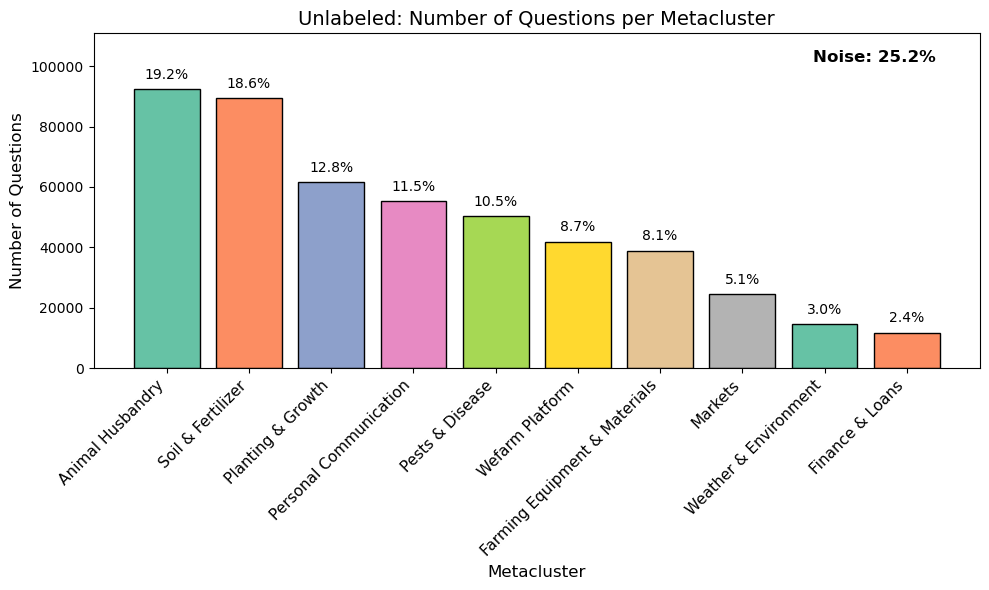

In [118]:
plot_metacluster_distribution(unlabeled_df, title="Unlabeled: Number of Questions per Metacluster")

In [89]:
## I've noticed a cluster that could be classified better-- I moved Cluster 68 from 'Personal Communication' to 'Farming Equipment & Materials'. This cluster seems to be mostly broad questions about farms (e.g. what is a farm?) 
## with maybe an emphasis on how to start one. This change just takes place here, so it will differ from the mapping in 'clustering_questions_unlabeled.ipynb'.
#  
## In case a future user wants to re-label other clusters, here's the mapping:

cluster_to_meta = {
    **dict.fromkeys([0, 12, 15, 16, 52, 53, 54, 57, 58, 59, 60, 83, 84, 87, 88, 91, 92, 98, 101, 108, 113, 118, 124, 126, 130, 137, 147, 151, 173, 175, 177, 182, 183, 188], 4),  # Planting & Growth
    **dict.fromkeys([1, 7, 9, 13, 34, 35, 45, 46, 47, 48, 85, 99, 107, 131, 133, 140, 144, 150, 165, 166, 168, 169], 2),  # Pests & Disease
    **dict.fromkeys([2, 3, 4, 5, 6, 10, 11, 14, 24, 26, 27, 29, 32, 55, 56, 81, 90, 95, 96, 102, 103, 117, 134, 143, 146, 156, 162, 171, 172, 178, 179, 191, 203], 3),  # Animal Husbandry
    **dict.fromkeys([8, 19, 20, 21, 22, 23, 33, 39, 40, 41, 43, 44, 49, 50, 65, 69, 75, 82, 94, 106, 110, 111, 114, 115, 116, 119, 120, 121, 123, 141, 142, 149, 153, 154, 155, 159, 164, 181, 210], 1),  # Soil, Fertilizer, & Animal Feed
    **dict.fromkeys([74, 122, 132, 148, 184, 185, 204, 205, 206, 207, 208, 209, 176, 174], 5),  # Markets
    **dict.fromkeys([17, 18, 71, 72, 186, 167, 163], 6),  # Finance & Loans
    **dict.fromkeys([25, 28, 31, 42, 68, 76, 86, 93, 100, 112, 129], 7),  # Farming Equipment & Materials
    **dict.fromkeys([30, 51, 97, 109, 128, 138, 180, 192], 8),  # Weather & Environment
    **dict.fromkeys([37, 61, 62, 67, 77, 80, 89, 139, 145, 187, 196, 198, 199], 9),  # Wefarm Platform
    **dict.fromkeys([36, 38, 63, 64, 70, 73, 78, 79, 125, 135, 136, 152, 157, 158, 160, 161, 189, 190, 193, 194, 195, 197, 200, 201, 202, 211, 212, 213, 214, 215, 216], 10),  # Personal Communication
    **dict.fromkeys([-1, 66, 104, 105, 127, 170], -1)  # Uncategorized
}
unlabeled_df['meta_label'] = unlabeled_df['cluster'].map(cluster_to_meta)
unlabeled_df['meta_label_titles'] = unlabeled_df['meta_label'].map(unlabeled_meta_titles)

In [138]:
from IPython.display import HTML
import io
import sys

def collapsible_preview(func, *args, summary_label="Show output", max_height="400px", **kwargs):
    """
    Runs a function that prints output, captures the printed text,
    and displays it in a collapsible, scrollable block.
    
    Returns whatever the function normally returns (e.g. a DataFrame).
    """
    
    # Capture printed output
    buffer = io.StringIO()
    stdout_original = sys.stdout
    sys.stdout = buffer
    
    result = func(*args, **kwargs)
    
    sys.stdout = stdout_original
    preview_text = buffer.getvalue()

    # Collapsible + scrollable block
    display(HTML(f"""
    <details>
      <summary>{summary_label}</summary>
      <div style="max-height: {max_height}; overflow-y: auto; border: 1px solid #ccc; padding: 8px;">
        <pre>{preview_text}</pre>
      </div>
    </details>
    """))
    
    return result



,cluster,size,keywords,samples
0,-1,34364,"hen, hens, chicken, chicks, eggs",[Q How can i start with one hen which is a lay...
1,0,11062,"vaccine, chicks, vaccinate, vaccination, chicken",[which vacines do we give to day old chicks an...
2,1,6842,"layers, layer, best, good, mash","[Q Layers has it's special feeds., Q How the h..."
3,2,5247,"chiken, chiks, chics, check, best","[Q,which way can lmake good chiken house, Whic..."
4,3,1755,"coccidiosis, chicken, cocidiosis, hens, medicine",[Q:What stage can chicks effected with Coccodi...
...,...,...,...,...
130,129,430,"eggs, eat, eating, causes, hen",[Q What bad effects do young pigs get after ea...
131,130,388,"eggs, hen, best, type, hens",[WHICH TYPE OF HENS ARE GOOD FOR EGG PRODUCTIO...
132,131,205,"eggs, hens, lay, hen, laying",[Q what do need to start keeping hens for eg...
133,132,683,"egg, lay, hen, eggs, double",[Q What enables a hen 2 lay an egg wiz 2 yorks...


In [140]:
unlabeled_summary = collapsible_preview(
    summarize_clusters,
    unlabeled_df,
    text_col='question_content',
    meta_col='meta_label_titles',
    sample_questions=5,
    preview=True,
    sort_by_size=True,
    summary_label="Unlabeled cluster summary"
)


In [139]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
unlabeled_summary = summarize_clusters(unlabeled_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        #random_samples = True
                        )

collapsible_preview(unlabeled_summary, summary_len=800, title="Unlabeled cluster summary")

TypeError: 'DataFrame' object is not callable

In [124]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
metacluster_preview(unlabeled_summary, 
                    metacluster_num=10, 
                    meta_titles=unlabeled_meta_titles)

Previewing Meta-cluster 10: Personal Communication

=== Cluster 73 (size=10253) ===
Keywords: answer, question, questions, ask, help
Sample questions:
  - Q you people ignored my message 
Atukundaire
  - E A Q22 ON AUGAST
  - Q I dont understand you!
  - E Did You Recieved My Question?
  - Q  i olso want 2 answer.

=== Cluster 79 (size=6616) ===
Keywords: english, county, kiswahili, kericho, district
Sample questions:
  - Q: i am found in kisii county
  - What Is Kayongo
  - q.nyeri county
  - What is the meaning of Nara by kakuru
  - Q Am located at kinangop, murungaru,,

=== Cluster 70 (size=6530) ===
Keywords: number, contact, phone, contacts, want
Sample questions:
  - E, RBT   1 :Nakupenda-5027362 2 :Joy To The World-51517137
  - Q i want herman's phone number
  - Q,Give her my no plz
  - Q. Do You Have Your Contact?
  - Q#,give Me your numbers so that we communicate

=== Cluster 36 (size=4860) ===
Keywords: sex, vagina, penis, semen, wat
Sample questions:
  - Q do male rbbts get 

## 'Chicken' Questions

This section will explore questions with the **chicken** tag, which represent 8.5% of the questions in English. Zoning in on one type of livestock question will hopefully reveal more global patterns in what information farmers are seeking about specific animals.

In [109]:
plot_umap_centroids(chicken_df, title="Chicken Questions - UMAP Centroids by Metacluster", size_scale=1)

As might be expected, the **chicken** focused clusters are more well-resolved than the **unlabeled** clusters-- an **unlabeled** metacluster like **Animal Husbandry** covers subject matter related to chickens, cows, goats, bees, and other animals. Focusing on chicken-specific content allows the clustering to capture finer distinctions within the topic, resulting in tighter, more clearly separated clusters.

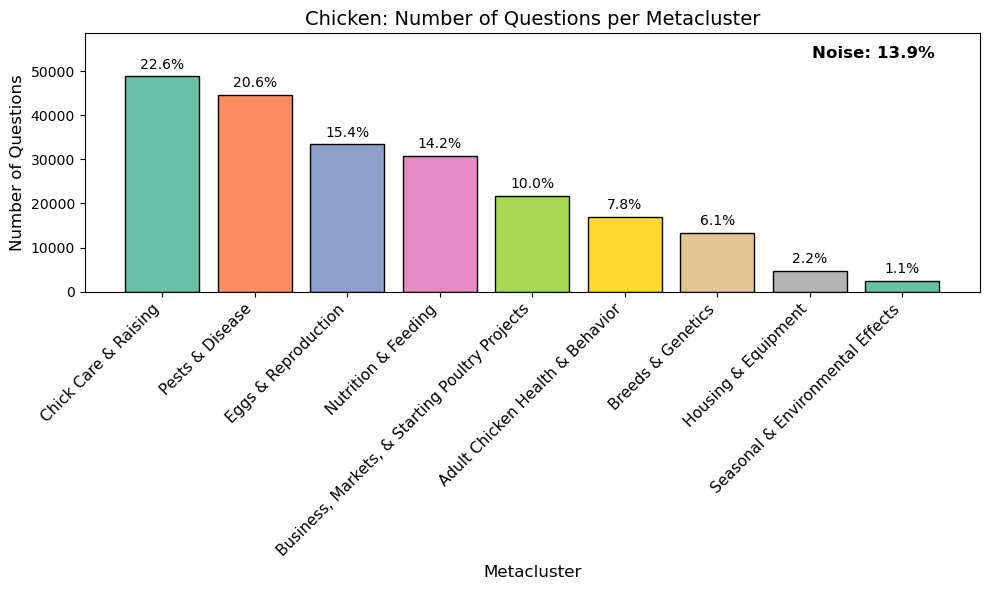

In [121]:
plot_metacluster_distribution(chicken_df, title="Chicken: Number of Questions per Metacluster")

In [ ]:
## ChatGPT meta cluster assignment. Provided in case future user wants to change metacluster assignment 
cluster_to_meta = {
    **dict.fromkeys([0, 2, 36, 41, 43, 49, 59, 66, 67, 68, 70, 85, 105, 108, 118, 120], 1),  # Chick Care & Raising
    **dict.fromkeys([1, 8, 20, 21, 37, 40, 57, 58, 61, 62, 69, 78, 80, 81, 86, 88, 89, 91, 94, 98, 125], 2),  # Nutrition & Feeding
    **dict.fromkeys([3, 4, 5, 6, 9, 10, 11, 12, 13, 26, 30, 31, 33, 34, 47, 50, 51, 79, 84, 87, 92, 95, 100, 101, 102, 103, 109, 110, 111, 112, 114, 115, 116], 3),  # Pests & Disease
    **dict.fromkeys([23, 24, 25, 27, 28, 29, 32, 35, 44, 77], 4),  # Adult Chicken Health & Behavior
    **dict.fromkeys([15, 22, 42, 46, 53, 74, 75, 96, 97, 130, 104], 5),  # Breeds & Genetics
    **dict.fromkeys([16, 17, 38, 40, 52, 54, 63, 64, 65, 71, 72, 73, 76, 83, 99, 107, 113, 122, 124, 128, 129, 131, 132, 133], 6),  # Eggs & Reproduction
    **dict.fromkeys([39, 90, 93], 7),  # Housing & Equipment
    **dict.fromkeys([7, 14, 45, 48, 55, 56, 60, 106, 121, 123, 126, 127], 8),  # Business & Poultry Projects
    **dict.fromkeys([18, 19, 117], 9),  # Seasonal & Environmental Effects
    **dict.fromkeys([-1, 82, 119], -1),  # Uncategorized
}
chicken_df['meta_label'] = chicken_df['cluster'].map(cluster_to_meta)

In [ ]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
chicken_summary = summarize_clusters(chicken_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        extra_stop_words = ["chicken", "chickens", "chiken"],
                        #random_samples = True
                        )


=== Cluster -1 (size=34364) ===
Keywords: hen, hens, chicks, eggs, lay
Meta: Uncategorized
Sample questions:
  - Q How can i start with one hen which is a layer to lay fertilized eggs  by a cock to grow into a big hen farm project?
  - Q what makes an egg  break inside the hen?
  - Q     Is my hen normal when it 'family plans' 4 3 yearz?
  - Q inform me of grade Chicken and their feeds, how to get, where and the cost
  - Q. what is the price of a cock or a male chicken?

=== Cluster 0 (size=11062) ===
Keywords: vaccine, chicks, vaccinate, vaccination, vaccines
Meta: Chick Care & Raising
Sample questions:
  - which vacines do we give to day old chicks and hw often do i vacinate them?
  - Q#I have vaccinated my indigenous chicken against newcastle diseases but all over asudden, they are dying one by one,wat could be the problem?
  - Q-i want to chicken vaccination medicines and what they prevent
  - I  request to know which vaccines I give to my kienyeji chicken
  - Q wot is th best vac

In [ ]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
metacluster_preview(chicken_summary, metacluster_num=1, meta_titles=chicken_meta_titles)

Previewing Meta-cluster 1: Chick Care & Raising

=== Cluster 0 (size=11062) ===
Keywords: vaccine, chicks, vaccinate, vaccination, vaccines
Sample questions:
  - which vacines do we give to day old chicks and hw often do i vacinate them?
  - Q#I have vaccinated my indigenous chicken against newcastle diseases but all over asudden, they are dying one by one,wat could be the problem?
  - Q-i want to chicken vaccination medicines and what they prevent
  - I  request to know which vaccines I give to my kienyeji chicken
  - Q wot is th best vaccine to a one day old chick

=== Cluster 68 (size=6608) ===
Keywords: chicks, chick, old, day, cost
Sample questions:
  - QHOW MUCH WILL I SALE CHICKS OF ONE MONTH
  - how much is a one day old chick
  - How much money do you sell one small chick?
  - Q where can i get chicks in nakuru @ how much
  - Q where can i buy chicks? Anyone here who has chicks?

=== Cluster 2 (size=5247) ===
Keywords: chiks, chics, best, start, check
Sample questions:
  - Q,w

## 'Maize' Questions

This subsection will explore questions tagged with **maize**, which represent 6.3% of the English questions and constitute the largest crop topic in the dataset. Perhaps because maize is a specific crop and plant care is more straightforward than animal care, the 2D clustering map shows the best distinction between metaclusters of the 3 topics analyzed.

In [115]:
plot_umap_centroids(maize_df, title="Maize Questions - UMAP Centroids by Metacluster", size_scale=1)

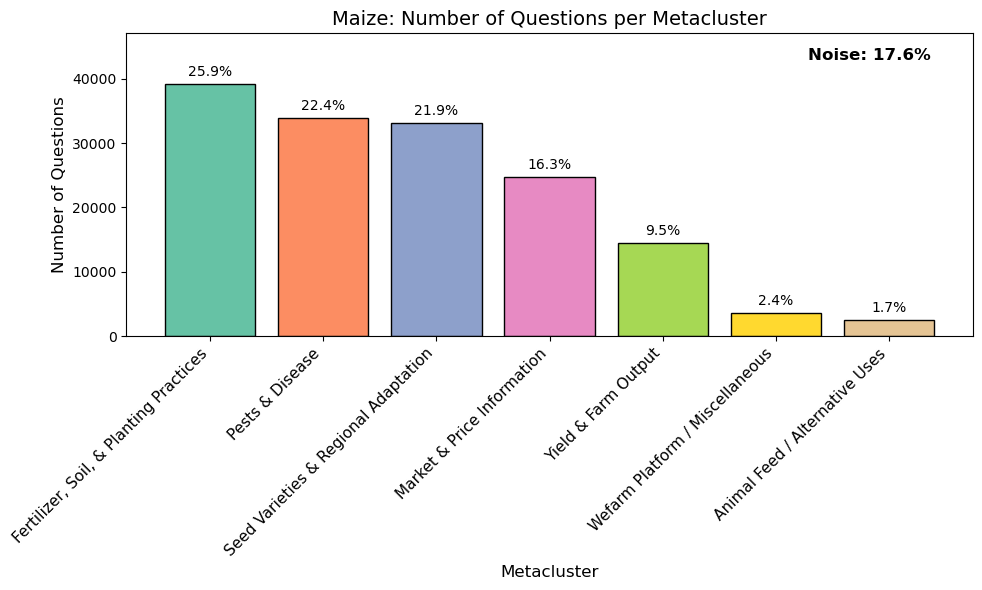

In [117]:
plot_metacluster_distribution(maize_df, title="Maize: Number of Questions per Metacluster")

In [ ]:
# Formatted meta cluster assignment by ChatGPT-- check for missing assignments
cluster_to_meta_maize = {
    **dict.fromkeys([0, 1, 2, 15, 22, 26, 27, 29, 42, 47, 48, 50, 52, 53, 58, 83, 85, 87, 93, 97, 98, 107, 113, 114, 115, 116, 117, 122, 128], 1),  # Pests & Disease
    **dict.fromkeys([3, 4, 6, 7, 8, 10, 13, 14, 16, 17, 18, 19, 20, 51, 54, 55, 56, 77, 79, 84, 88, 90, 103, 104, 118, 120, 123, 127, 129, 134, 136, 138, 139], 2),  # Fertilizer, Soil, & Planting Practices
    **dict.fromkeys([12, 21, 23, 24, 25, 38, 39, 40, 41, 43, 46, 60, 65, 68, 69, 70, 71, 76, 78, 80, 81, 82, 91, 94, 95, 99, 100, 101, 102, 105, 106, 121, 124, 126, 133], 3),  # Seed Varieties & Regional Adaptation
    **dict.fromkeys([31, 33, 59, 63, 64, 66, 67, 72, 74, 75, 125, 131, 132, 135], 4),  # Yield & Farm Output
    **dict.fromkeys([9, 11, 28, 30, 32, 34, 35, 36, 37, 92, 96, 108, 109, 110, 111, 112, 119, 137], 5),  # Market & Price Information
    **dict.fromkeys([44, 45, 86, 89, 130], 6),  # Animal Feed / Alternative Uses
    **dict.fromkeys([49, 57, 61, 62, 140], 7),  # Wefarm / Miscellaneous
    **dict.fromkeys([-1, 5, 73], -1),  # Uncategorized / Noise
}
maize_df['meta_label'] = maize_df['cluster'].map(cluster_to_meta_maize)

In [128]:
# Generate summary of clusters, with largest at the top. Includes TF-IDF keywords and 5 example questions by default. Extra stop words can be added for TF-IDF if necessary.
maize_summary = summarize_clusters(maize_df, 
                        text_col='question_content',
                        meta_col='meta_label_titles',
                        sample_questions = 5, 
                        preview = True,
                        sort_by_size = True,
                        extra_stop_words = ["maize", "plant"],
                        #random_samples = True
                        )


=== Cluster -1 (size=28332) ===
Keywords: best, type, planting, use, good
Meta: Uncategorized / Noise
Sample questions:
  - Q is maize separated to a male and female flower
  - Qn.Ways Of Preventing Parasites In Maize Field
  - If is busia have good market of maize at how much per kilo cost.
  - Which the best maize in githunguri climate
  - Q i didn't ask about cabbage variety,but which maize hybrid can do well in baringo county

=== Cluster 30 (size=12270) ===
Keywords: price, market, cost, sell, current
Meta: Market & Price Information
Sample questions:
  - What is the current maize prices?
  - E I Need To Know The Price Of Maize
  - I want to know the price of maize
  - which is price of maize.
  - Which place that have good market of maize.

=== Cluster 10 (size=8526) ===
Keywords: fertilizer, best, planting, use, apply
Meta: Fertilizer, Soil, & Planting Practices
Sample questions:
  - Q ,HOW MANY TIMES  AND INTERVALS  OF SPRAYING  FOLIAS  ON GROWING MAIZE
  - Which is the best f

In [129]:
# Adjust metacluster_num to examine a specific metacluster. Dependent on summarize_clusters() output.
metacluster_preview(maize_summary, metacluster_num=1, meta_titles=maize_meta_titles)

Previewing Meta-cluster 1: Pests & Disease

=== Cluster 42 (size=6016) ===
Keywords: yellow, leaves, yellowish, colour, turn
Sample questions:
  - Q:Why do maize plants turn yellow
  - Q  how can i treat maize turning yellow  in my farm?
  - Q# Maize is changing colour to pulple andgreyies what is the problem and cure
  - Q my maize are turning yellowish how can I prevent it
  - Q my maize are turning yellow while still young

=== Cluster 0 (size=5997) ===
Keywords: worms, army, worm, control, armyworm
Sample questions:
  - Which is the best dawa in the market to spray armyworm in maize?
  - How do we control amywarms on maize?
  - Q How can I control armyworms in maize plantation
  - what is the control of cut worms in maize
  - pestcide used to spray on maize plants to control cutworms

=== Cluster 47 (size=3565) ===
Keywords: pests, pest, control, insects, insect
Sample questions:
  - How Can Jcontrol Insects In My Maize Garden Which Not Ready To Be Harvested?
  - WHAT IS THE MAJOR 